## 1. Dependencies

cousre 저장소 다운로드, 실습 관련 패키지 import

In [30]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Import
import random
from random import sample
import matplotlib.pyplot as plt
import pandas as pd 

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
#assert len(tf.config.list_physical_devices('GPU')) > 0

지정된 경로를 찾을 수 없습니다.


## 2. Dataset

817 songs, 200,679 vectorized songs

- ABC notation으로 표현된 수천 개의 아일랜드 민요(Irish folk songs) 데이터 
- 단순히 연주되는 음에 대한 정보만이 아니라 추가적으로 노래 제목, 키, 템포와 같은 메타 정보도 포함함 
- **텍스트 파일에 존재하는 다양한 문자들이 complexity of the learning problem에 어떤 영향을 미칠까?**
- 위 문제는 텍스트 데이터를 수치 데이터로 만들때 중요해짐 : Preprocessing
- 음악데이터만 사용하려면 어떻게 해야 할까요? 
- NLP 적인 처리가 필요하지 않을까? 
    - X : number
    - T : title, 제목
    - Z : ?? 음자리표인감 높은음자리표 이런거.. 
    - M : 뭐지? 첫 시작음? 
    - L : 박자표인듯
    - K : key, 음계, 다장조 이런거 
    - z : 악보, 우리가 실제로 훈련해야 할 것, 여기서 | 이거는 마디, !는 뭔지 모르겠음 :| 도돌이표
- **songs** : 817개의 노래가 들어있는 list
- **show_music_detail(num)** : num 개의 음악을 자세하게 볼 수 있습니다 
- **mdl.lab1.play_song(example_song)** : text형 음악을(ABC notation) audio 파형으로 표현합니다 

In [31]:
# Download the dataset
# colab으로 실행한다면 주석과 같이 작성할 것 
# jupyter notebook으로 실행한다면 아래와 같이 작성할 것 
# import pattern과 관련해서 수정해주어야 오류가 해결되는 것 같습니다

from mitdeeplearning import lab1
#songs = mdl.lab1.load_training_data()
songs = lab1.load_training_data()

Found 817 songs in text


In [32]:
# Print one of the songs to instpect it in greater detail! 
# my function -> Print N of the song... 
def show_music_detail(songs, num) :
    num_list = sample(range(0, len(songs)), num) #sample output format is list
    for i in num_list :
        example_song = songs[i]
        print("\nExample song #", i, ":")
        print(example_song)

show_music_detail(songs, 1)


Example song # 414 :
X:87
T:Earl's Chair
Z: id:dc-reel-81
M:C
L:1/8
K:D Major
A|B2dA BAFA|B2dA BAFB|AFF2 DFF2|BAdA BDFA|!
B2dA BAFA|B2dA BAFB|A3B defd|edef d3:|!
f|e3f d3f|edef dBA2|e3f d3e|fedB ADFA|!
e2df eBB2|gBB2 defg|afbf afde|fedB ADF:|!


In [33]:
example_song = songs[random.randint(0, len(songs))]
mdl.lab1.play_song(example_song)

## 3. Preprocessing

1. Vectorize the text 
2. Make input sequence chunk from input text (and target sequence)

- Prediction task :RNN 모델이 ABC notation 음악에서 패턴을 학습하도록 훈련할 것이며, 학습한 정보를 바탕으로 새로운 음악 생성(또는 예측)
- 즉, 모델에게 정말로 요구하는 것은 문자, 문자들의 시퀀스, 다음 문자로 올 가장 가능성 높은 문자는 무엇인가? 
- input : 문자열 시퀀스 -> model -> output : 각 time step 에서 다음 문자를 예측하는 것 

### Vectorize the text

- 텍스트(text) 데이터셋 -> 수치(numerical) 데이터셋 => Vectorize 
    - **vocab**     : ABC notation에 있는 unique vocabulary(or character) 
    - **char2idx** : 문자 -> 숫자 mapping, 정수  
    - **idx2char** : 숫자 -> 문자 mapping 
    - **vectorized_songs** : ABC notation 노래 text에서 벡터화된 노래 

In [5]:
### Vectorize the songs string ###
# 문자열 벡터화 함수, return은 무조건 'N(입력 문자열의 문자 개수)'요소의 np.array
def vectorize_string(string):
    # TODO
    string = str(string)
    vectorized_list = []
    vectorized_list = ([char2idx[_] for _ in string])
    return vectorized_list

In [6]:
# Join our list of song strings into a single string containing all songs
# 노래 문자열(string) 목록을 이 모든 노래가 포함된 하나의 단일 문자열로 결합함
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
# 결합된 노래 묶음 문자열에서 유일한(unique) 단어들을 모두 확인
# 데이터셋에는 총 83개의 유일한 문자들이 존재함
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")


### Define numerical representation of text ###  
# 문자 -> unique index로 매핑
# 예를 들어, "d"라는 문자의 인덱스는 char2idx["d"]와 같이 작성하여 얻을 것임 
char2idx = {u:i for i, u in enumerate(vocab)}

# index -> 문자로 매핑 
# char2idx의 반대 버전이며 index에서 다시 문자로 되돌리는 역할을 할 것임
idx2char = np.array(vocab)

# [python] difference between str() and repr() 
# 숫자를 문자열로 변환시켜주는 함수임은 동일합니다. 하지만 기저에 작동하는 원리가 다른 것 같습니다. 
print(char2idx)

There are 83 unique characters in the dataset
{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '<': 23, '=': 24, '>': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '^': 54, '_': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '|': 82}


In [7]:
input_data = pd.DataFrame(songs, columns = ["songs"])
input_data.head()

,songs
0,X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\...
1,X:2\nT:An Buachaill Dreoite\nZ: id:dc-hornpipe...
2,X:3\nT:Belfast\nZ: id:dc-hornpipe-3\nM:C|\nL:1...
3,X:4\nT:Blackbird\nZ: id:dc-hornpipe-4\nM:C|\nL...
4,X:5\nT:Bobby Casey's\nZ: id:dc-hornpipe-5\nM:C...


In [8]:
# split 
input_data[['X', 'temp']] = input_data['songs'].str.split("\nT:", expand=True)
input_data['T'] = input_data['temp'].str.split("\nZ:").str[0]
input_data['temp'] = input_data['temp'].str.split("\nZ:").str[1]
input_data['Z'] = input_data['temp'].str.split("\nM:").str[0]
input_data['temp'] = input_data['temp'].str.split("\nM:").str[1]
input_data['M'] = input_data['temp'].str.split("\nL:").str[0]
input_data['temp'] = input_data['temp'].str.split("\nL:").str[1]
input_data['L'] = input_data['temp'].str.split("\nK:").str[0]
input_data['temp'] = input_data['temp'].str.split("\nK:").str[1]
input_data['K'] = input_data['temp'].str.split("\n").str[0]
input_data['score'] = input_data['temp'].str.split("\n").str[1]

# drop and applying 
input_data['X'] = input_data['X'].str.split("X:").str[1]
input_data = input_data.drop(columns = ['temp'])
input_data["score"] = input_data["score"].apply(str)

# vectorized string 
input_data["vectorized"] = ""
for i in range (0, 817) : 
    input_data["vectorized"][i] = vectorize_string(input_data["score"][i])

    
input_data

,songs,X,T,Z,M,L,K,score,vectorized
0,X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\...,1,Alexander's,id:dc-hornpipe-1,C|,1/8,D Major,(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dc...,"[6, 15, 26, 27, 58, 82, 59, 26, 31, 26, 1, 29,..."
1,X:2\nT:An Buachaill Dreoite\nZ: id:dc-hornpipe...,2,An Buachaill Dreoite,id:dc-hornpipe-2,C|,1/8,G Major,GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!,"[32, 31, 82, 29, 32, 32, 27, 1, 59, 14, 32, 27..."
2,X:3\nT:Belfast\nZ: id:dc-hornpipe-3\nM:C|\nL:1...,3,Belfast,id:dc-hornpipe-3,C|,1/8,D Major,ag|(3faf df AdFA|DFAd f2ef|gbec dfAF|GABG E2ag|!,"[56, 62, 82, 6, 15, 61, 56, 61, 1, 59, 61, 1, ..."
3,X:4\nT:Blackbird\nZ: id:dc-hornpipe-4\nM:C|\nL...,4,Blackbird,id:dc-hornpipe-4,C|,1/8,D Mixolydian,AG|F2FA GFD2|de (3fed d^cAF|G2GF GFDE|FdcA G2AG|!,"[26, 32, 82, 31, 14, 31, 26, 1, 32, 31, 29, 14..."
4,X:5\nT:Bobby Casey's\nZ: id:dc-hornpipe-5\nM:C...,5,Bobby Casey's,id:dc-hornpipe-5,C|,1/8,A Dorian,ed|cAAB cBcd|eaaf gedB|c2Ac B2Bc|d2de dBGB|!,"[60, 59, 82, 58, 26, 26, 27, 1, 58, 27, 58, 59..."
...,...,...,...,...,...,...,...,...,...
812,X:6\nT:Inisheer\nZ: id:dc-waltz-4\nM:3/4\nL:1/...,6,Inisheer,id:dc-waltz-4,3/4,1/8,G Major,D2|B3 A Bd|B3 A Bd|E3 B AB|D3 E GA|!,"[29, 14, 82, 27, 15, 1, 26, 1, 27, 59, 82, 27,..."
813,X:7\nT:Mrs. Kenny's\nZ: id:dc-waltz-7\nM:3/4\n...,7,Mrs. Kenny's,id:dc-waltz-7,3/4,1/8,D Major,"A2|f2 fe dc|d4 FG|A2 G3B,|A,2 C2 E2|!","[26, 14, 82, 61, 14, 1, 61, 60, 1, 59, 58, 82,..."
814,X:8\nT:South Wind\nZ: id:dc-waltz-5\nM:3/4\nL:...,8,South Wind,id:dc-waltz-5,3/4,1/8,G Major,c2|B3 A G2|B3 c d2|A6|A4 c2|B3 A G2|E3 D E2|G6...,"[58, 14, 82, 27, 15, 1, 26, 1, 32, 14, 82, 27,..."
815,X:9\nT:Spinning Wheel\nZ: id:dc-waltz-11\nM:3/...,9,Spinning Wheel,id:dc-waltz-11,3/4,1/8,G Major,D|G2 B3 D|G2 B2 D2|G2 B2 d2|d2 c2 AG|F2 A2 D2|...,"[29, 82, 32, 14, 1, 27, 15, 1, 29, 82, 32, 14,..."


In [9]:
input_data["M"].value_counts()

C      400
6/8    228
C|      89
2/4     54
9/8     22
3/4     19
4/4      3
Name: M, dtype: int64

In [10]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data['K'] = le.fit_transform(list(input_data['K']))   # fit transform으로 한번에 처리 가능
print(le.classes_)

input_data

['A Dorian' 'A Major' 'A Minor' 'A Mixolydian' 'B Dorian' 'B Minor'
 'C Major' 'D Dorian' 'D Major' 'D Minor' 'D Mixolydian' 'E Dorian'
 'E Major' 'E Minor' 'F Major' 'F# Minor' 'G Dorian' 'G Major'
 'G Mixolydian' None]


,songs,X,T,Z,M,L,K,score,vectorized
0,X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\...,1,Alexander's,id:dc-hornpipe-1,C|,1/8,8,(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dc...,"[6, 15, 26, 27, 58, 82, 59, 26, 31, 26, 1, 29,..."
1,X:2\nT:An Buachaill Dreoite\nZ: id:dc-hornpipe...,2,An Buachaill Dreoite,id:dc-hornpipe-2,C|,1/8,17,GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!,"[32, 31, 82, 29, 32, 32, 27, 1, 59, 14, 32, 27..."
2,X:3\nT:Belfast\nZ: id:dc-hornpipe-3\nM:C|\nL:1...,3,Belfast,id:dc-hornpipe-3,C|,1/8,8,ag|(3faf df AdFA|DFAd f2ef|gbec dfAF|GABG E2ag|!,"[56, 62, 82, 6, 15, 61, 56, 61, 1, 59, 61, 1, ..."
3,X:4\nT:Blackbird\nZ: id:dc-hornpipe-4\nM:C|\nL...,4,Blackbird,id:dc-hornpipe-4,C|,1/8,10,AG|F2FA GFD2|de (3fed d^cAF|G2GF GFDE|FdcA G2AG|!,"[26, 32, 82, 31, 14, 31, 26, 1, 32, 31, 29, 14..."
4,X:5\nT:Bobby Casey's\nZ: id:dc-hornpipe-5\nM:C...,5,Bobby Casey's,id:dc-hornpipe-5,C|,1/8,0,ed|cAAB cBcd|eaaf gedB|c2Ac B2Bc|d2de dBGB|!,"[60, 59, 82, 58, 26, 26, 27, 1, 58, 27, 58, 59..."
...,...,...,...,...,...,...,...,...,...
812,X:6\nT:Inisheer\nZ: id:dc-waltz-4\nM:3/4\nL:1/...,6,Inisheer,id:dc-waltz-4,3/4,1/8,17,D2|B3 A Bd|B3 A Bd|E3 B AB|D3 E GA|!,"[29, 14, 82, 27, 15, 1, 26, 1, 27, 59, 82, 27,..."
813,X:7\nT:Mrs. Kenny's\nZ: id:dc-waltz-7\nM:3/4\n...,7,Mrs. Kenny's,id:dc-waltz-7,3/4,1/8,8,"A2|f2 fe dc|d4 FG|A2 G3B,|A,2 C2 E2|!","[26, 14, 82, 61, 14, 1, 61, 60, 1, 59, 58, 82,..."
814,X:8\nT:South Wind\nZ: id:dc-waltz-5\nM:3/4\nL:...,8,South Wind,id:dc-waltz-5,3/4,1/8,17,c2|B3 A G2|B3 c d2|A6|A4 c2|B3 A G2|E3 D E2|G6...,"[58, 14, 82, 27, 15, 1, 26, 1, 32, 14, 82, 27,..."
815,X:9\nT:Spinning Wheel\nZ: id:dc-waltz-11\nM:3/...,9,Spinning Wheel,id:dc-waltz-11,3/4,1/8,17,D|G2 B3 D|G2 B2 D2|G2 B2 d2|d2 c2 AG|F2 A2 D2|...,"[29, 82, 32, 14, 1, 27, 15, 1, 29, 82, 32, 14,..."


In [11]:
major_list = [1, 6, 8, 12, 14, 17]
minor_list = [2, 5, 9 ,13, 15]

for j in major_list : 
    major_index = input_data[input_data['K']==j].index 
    input_major = input_data.loc[major_index, :]
    

In [12]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   songs       817 non-null    object
 1   X           815 non-null    object
 2   T           815 non-null    object
 3   Z           815 non-null    object
 4   M           815 non-null    object
 5   L           815 non-null    object
 6   K           817 non-null    int32 
 7   score       817 non-null    object
 8   vectorized  817 non-null    object
dtypes: int32(1), object(8)
memory usage: 54.4+ KB


In [13]:
input_data[input_data["L"].isna()]

,songs,X,T,Z,M,L,K,score,vectorized
23,"A,C|D2 (3DDD DFAA|defe dcBA|FAA2 BAAF|GEFD CEA...",NaN,None,None,None,None,19,None,"[39, 70, 69, 60]"
630,E3F D2FA|d2fd gdfd|edBd A2FA|B2AF GFED|!\nE3F ...,NaN,None,None,None,None,19,None,"[39, 70, 69, 60]"


In [14]:
vectorized_songs = []

for i in range(817) : 
    vectorized_songs += input_data["vectorized"][i]
    
vectorized_songs = np.array(vectorized_songs)
vectorized_songs

array([ 6, 15, 26, ..., 61, 82,  2])

### Create training examples and targets

- 실제 텍스트를 훈련 중에 사용할 예제 시퀀스로 나눌 것
- 입력 텍스트를 seq_length 단위로 나눔
- 예를 들어 텍스트는 Hello 이고 seq_length가 4라면 hell가 input, elloo가 target이 됨 
- 이로부터 batch 방법을 사용하여 해당 문자 인덱스 스트림을 원하는 크기의 시퀀스로 변환 가능 
- 각각의 벡터,각각의 index는 하나의 단일 time step으로 처리 
- 즉, time step 0 은 들어온 시퀀스의 첫 번째 문자에 대한 인덱스를 받고 그 다음 인덱스 1의 문자를 맞출 것 

In [15]:
### Batch definition to create training examples ###
def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1 # 200679 - 1 = 200678 
    # randomly choose the starting indices for the examples in the training batch
    # 0 ~ 200678-seq_length 숫자 사이에서 batch_size개의 임의의 표본 추출 -> 즉 batch size가 n개면 idx도 n개 나옴
    idx = np.random.choice(n-seq_length, batch_size) 
    print("idx: ", idx) 
    
    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
    print("input batch: ", len(input_batch)) # batch size 는 seq_length 값과 동일, 그래서 step의 수도 0~seq_length-1 까지임! 
    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
    print("output batch: ", len(output_batch))
    
    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch

In [16]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

idx:  [25521]
input batch:  1
output batch:  1
Step   0
  input: 60 ('e')
  expected output: 59 ('d')
Step   1
  input: 59 ('d')
  expected output: 58 ('c')
Step   2
  input: 58 ('c')
  expected output: 82 ('|')
Step   3
  input: 82 ('|')
  expected output: 27 ('B')
Step   4
  input: 27 ('B')
  expected output: 32 ('G')


## 2.4 The Recurrent Neural Network (RNN) model

 모델은 LSTM 구조를 기반하는데, 이 구조는 연속되는 문자들 사이의 시간 관계(temporal relationships)에 대한 정보를 유지하는 state 벡터를 사용합니다. LSTM의 최종 출력은 fully-connected `Dense` layer로 넘겨지는데, 여기서 vocabulary의 각 문자에 대해 softmax를 계산하고(출력하고) 이로부터 만들어진 불포에서 샘플을 추춘하여 다음 문자를 예측합니다. 

* keras API [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential)를 사용합니다. 모델을 정의하기 위해 세 개의 레이어가 사용됩니다. 
* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) : 입력 레이어, 각 문자의 숫자들을 `embedding_dim`차원의 벡터로 매핑하는 훈련 가능한 lookup 테이블로 구성됨 
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): `units=rnn_units` 크기의 LSTM 신경망
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): `vocab_size` 출력이 있는 출력 레이어
* `Model.summary` : 모델의 내부 작동에 대한 summary를 출력, 모델 내부의 레이어, 각 레이어의 출력 형태(shape), 배치 사이즈 등을 확인해 볼 수 있습니다.

<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

In [17]:
# define model function 
def LSTM(rnn_units): 
    return tf.keras.layers.LSTM(
        rnn_units, 
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True,
  )

In [18]:
### Defining the RNN Model ###
'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

        # Layer 2: LSTM with `rnn_units` number of units. 
        # TODO: Call the LSTM function defined above to add this layer.
        LSTM(rnn_units),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size. 
        # TODO: Add the Dense layer.
        tf.keras.layers.Dense(vocab_size)
  ])
    return model

# Build a simple model with default hyperparameters. You will get the chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### Test out the RNN model

모델의 예상 작동을 확인하기 위한 간단한 테스트 시행합니다. 길이 100의 시퀀스를 사용하여 출력물의 차원도 확인해보자. 
**모델에는 어떤 길이의 입력도 동작할 수 있음을 주의!**

In [20]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

idx:  [15951  7852  5800 11465 27561 26433 14596 29636 11712 27748  1249 21920
 17576  2812 32005 31395  4848 21074 22037 14644 11477 16561 24773 17593
  7473 32189 15915 18204 21350  2428 13348 10398]
input batch:  32
output batch:  32
Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

훈련시키지 않은 모델의 예측은 어떨까? 

모델의 실제 예측을 얻기 위해서, 우리는 문자 vocabulary를 `softmax`로 정의한 출력 분포에서 샘플을 추출해야 합니다. 이는 우리에게 실제 문자 인덱스틀 제공합니다. 즉, 범주형 분포([categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) )을 사용하여 예제 예측을 샘플로 추출함을 의미합니다. 이로써 각 time step에서 다음 문자(특히나 그 인덱스에서의)에 대한 예측을 하게 됩니다. 

여기서는 단순히 `argmax`를 취하는 대신 확률 분포에서 표본을 추출합니다. (그리고 argmax는 모델이 루프에 빠지게 만들 수 있습니다?)

첫 번째 예시 batch에서 샘플링을 실행해봅시다. 

In [21]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([34, 35, 71, 47, 25, 27, 56, 10,  1, 17, 45,  9, 18, 18, 69, 81, 48,
       53, 62, 30, 70, 52, 26,  7, 40, 40, 26, 17, 13, 52, 24, 27, 54, 82,
       56, 67, 76, 26, 60, 60, 17, 34,  6, 80, 48, 70, 70, 27,  7, 35, 29,
        3, 66, 43, 79, 62, 73, 60, 26, 39,  8,  0, 33, 45, 47, 76, 71, 38,
       76, 29,  6, 29, 79, 41, 52, 43, 11, 16,  3, 18, 59, 77, 40, 61, 24,
       61, 47, 80, 37, 21, 24, 17, 77, 76, 82, 40, 20, 25, 61, 79],
      dtype=int64)

이제 이들을 디코딩하여 훈련되지 않은 모델이 예측한 텍스트를 확인할 수 있습니다. 

In [22]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'BG AFEA:|[2 cABc ABcd|]!d|cFF2 cFdF|cFFG AGG2|cFAc dAcA|GcAG FDDd|!G3B dBB2|dBeB dBAB|GBB2 dBB2|dBAB'

Next Char Predictions: 
 'IJpV>Ba. 5T-66nzW]gEo[A)OOA51[=B^|aluAee5I(yWooB)JD"kRxgreAN,\nHTVupMuD(DxP[R/4"6dvOf=fVyL9=5vu|O8>fx'


## 2.5 Training the model: loss and training operations

다음 문자를 예측하는 문제를 일반적으로 분류 문제(classification, 여기서는 이진 분류가 아닌 multi-class)로 생각해 볼 수 있습니다. 
RNN의 이전 state와 주어진 time step에서의 입력을 고려하여 다음 문자에 대한 class를 예측해야 합니다.

### loss 
해당 분류 작업에 대해 모델을 훈련시키기 위해 `crossentropy` loss 형태를 사용할 수 있습니다. 특히나, `sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss를 사용할 것인데, 해당 loss는 범주형 분류 작업을 위해 정수 타겟을 사용하기 때문입니다. 실제 타겟(`labels`)과 예측 타겟(`logits`)을 사용하여 loss를 계산하는 방식입니다.  

### hyper parameter tuning 
시작값 제공, 최적의 파라미터는 여러분들이 찾아보세요~

### optimizer and training operation 
optimizer와 epochs은 신경망 출력에 영향을 줄 수 있음 
- 아래는 시도해볼만 한 optimizer
- [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable)
- [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable) 

Backpropagation은 [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape)를 사용 

훈련 동안 모델의 진행 상황을 출력하여 loss를 최소화하고 있는지에 대한 여부를 시각화함

### Benchmarking 
1. No-trained model -> scalar loss : 4.418331 

In [23]:
### Defining the loss function ###
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
    return loss

'''TODO: compute the loss using the true next characters from the example batch 
and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4194446


In [24]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

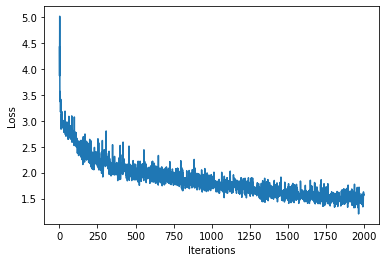

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:08:44<00:00,  2.06s/it]


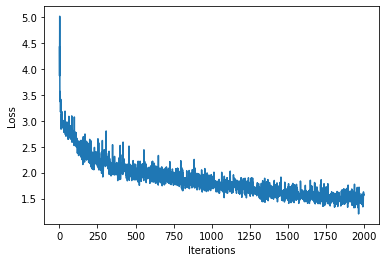

In [25]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:
        '''TODO: feed the current input into the model and generate predictions'''
        y_hat = model(x)
  
        '''TODO: compute the loss!'''
        loss = compute_loss(y, y_hat)

    # Now, compute the gradients 
    '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
    grads = tape.gradient(loss, model.trainable_variables)
  
    # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
    # Save the trained model and the weights
    model.save_weights(checkpoint_prefix)


## 2.6 Generate music using the RNN model : Inference

음악을 만들어낼 때, 모델의 시작을 위해 몇 가지 시드를 공급해야 합니다. 

일단 생성된 시드를 가지고 나면, 훈련된 RNN을 사용하여 각각의 연속적인 문자를 반복적으로 예측할 수 있습니다. 보다 구체적으로, RNN은 가능한 연속적인 문자로 `softmax`를 출력한다는 것을 기억하자. 추론(Inference)을 하는 동안, 이런 분포로부터 반복적으로 표본을 추출한 다음 생성된 노래를 ABC 표기법으로 인코딩하는 데 샘플을 사용합니다. 


### Restore the latest checkpoint

- 추론(Inference) 단계를 간단하게 하기 위해서 공정 batch 크기는 1로 사용
    - RNN의 state가 timestep에서 timestep으로 전달되는 방식 때문에, 모델은 오로지 한번 설정된 고정 batch 크기만을 수용할 수 있습니다. 
    - 다른 batch_size 모델을 실행하려면 rebuilding 해야 하고 훈련 중 마지막 checkpoint 이후의 가중치를 복원해야 함  

In [26]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### The prediction procedure

- "시드" 시작 문자열과 RNN state를 초기화 하고, 생성할 문자 수를 설정합니다.
- 시작 문자열과 RNN state를 사용하여 다음 예측 문자에 대한 확률 분포를 얻습니다. 
- 예측 문자의 인덱스를 계산하기 위해 다항 분포 표본으로부터 샘플링합니다. 그런 다음 이 예측 문자를 모델의 다음 입력으로 사용합니다. 
- 각 time step에서, 업데이트 된 RNN state는 다시 모델에 공급되어, 다음 예측을 만들 때 더 많은 컨텍스트(context)를 갖게 됩니다. 다음 문자를 예측한 후, 업데이트 된 RNN states는 다시 모델에 공급되고, 이는 이전 예측으로부터 더 많은 정보를 얻기 때문에 데이터 속에서 시퀀스 종속성을 학습하게 하는 방법이 됩니다. 

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)


In [27]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
    # Evaluation step (generating ABC text using the learned RNN model)

    '''TODO: convert the start string to numbers (vectorize)'''
    #input_eval = [vectorize_string(start_string)]
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        '''TODO: evaluate the inputs and generate the next character predictions'''
        predictions = model(input_eval)
      
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
      
        '''TODO: use a multinomial distribution to sample'''
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)
      
        '''TODO: add the predicted character to the generated text!'''
        # Hint: consider what format the prediction is in vs. the output
        text_generated.append(idx2char[predicted_id])
    
    return (start_string + ''.join(text_generated))

In [28]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.26it/s]


### Play back the generated music!

ABC notation text audio -> audio file 로 변환 후 생성된 노래 확인  

In [29]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
    # Synthesize the waveform from a song
    waveform = mdl.lab1.play_song(song)

    # If its a valid song (correct syntax), lets play it! 
    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)

Found 0 songs in text
